# Additional: estimate influence of `learning_rate` and `dropr`

In [1]:
import os
import pandas as pd
import numpy as np 
import torch
import pickle
from data.prepareData import prepareDataLoader_fromPkl
import json
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.python.summary.summary_iterator import summary_iterator

pd.set_option('display.max_columns', 0)

2022-12-01 15:24:55.314441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/easybuild/software/Python/3.9.5-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/OpenSSL/1.1/lib:/opt/ohpc/pub/easybuild/software/libffi/3.3-GCCcore-10.3.0/lib64:/opt/ohpc/pub/easybuild/software/libffi/3.3-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/GMP/6.2.1-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/XZ/5.2.5-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/SQLite/3.35.4-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/Tcl/8.6.11-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/libreadline/8.1-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/ncurses/6.2-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/bzip2/1.0.8-GCCcore-10.3.0/lib:/opt/ohpc/pub/easybuild/software/binutils/2.36.1-GCCcore-10.3.

In [2]:
def getValLoss(name):
    for file in os.listdir(f"{name}"):
        if file.startswith("events"):
            val_loss = []
            try:
                for summary in summary_iterator(f"{name}/{file}"):
                    if summary.summary.value:
                        if summary.summary.value[0].tag == "Val - Loss":
                            val_loss.append(summary.summary.value[0].simple_value)
            except UnboundLocalError:
                print("error during val loss scoring")
    return np.array(val_loss[-10:]).mean()

def getPearsonR(orig, recon):
    from scipy.stats import pearsonr
    pearson = []
    for i in range(recon.shape[1]):
        pearson.append(pearsonr(orig.detach().numpy()[:,i], recon[:,i])[0])
    return np.array(pearson).mean()

def getScores(path, test_tensor, dict_scoring, save=True):

    ### Load model
    model = torch.load(f"{path}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))
              
    # Get recon and latent space (from test data)
    with torch.no_grad():
        recon = model(test_tensor).detach().numpy()
        latSpace = model.generate_embedding(test_tensor)   

    try: 
        dict_scoring["chr"].append(CHR)
        dict_scoring["latSize"].append(path.split("/")[-1].split("_")[1])
        dict_scoring["lr"].append(path.split("/")[-1].split("_")[3])   
        dict_scoring["dropr"].append(path.split("/")[-1].split("_")[5])
        dict_scoring["pearson_mean"].append(getPearsonR(orig=test_tensor, recon=recon))
        #name = f"logs/{path}"    ##### THIS IS THE WORNG PATH FOR THE FUTURE! remove logs    
        dict_scoring["loss_mean"].append(getValLoss(path))
    except RuntimeWarning: 
        print("error")
        
    return dict_scoring

def getRanking(dict_scores):
    df = pd.DataFrame.from_dict(dict_scoring, orient="index").T

    ## Rank Pearson reconstruction accuracy - higher values better; 1 is best!
    df = df.sort_values("pearson_mean", ascending=False)
    df["idx_pearson"] = range(1,len(df)+1)

    ## Rank val loss - lower values better; 1 is best!
    df = df.sort_values("loss_mean", ascending=True)
    df["idx_loss"] = range(1,len(df)+1)

    ## Calcualte mean() ranking --> the lower the better (balance between loss and recon acc)
    df["idx_mean"] = df[["idx_pearson", "idx_loss"]].mean(axis=1)
    df = df.sort_values("idx_mean", ascending=True)
    return df

In [12]:
''' 
Determine influence of learning rate
'''
plt.rcParams.update({'font.size': 18})
PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"

### Initialise results dict
dict_scoring = dict()
for key in ["chr", "latSize", "lr", "dropr", "pearson_mean", "loss_mean"]:
    dict_scoring[key] = []

for CHR in ["chr22"]:
    ### Load Data
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)    
    ### Parse through learning rates:
    for lrSetting in [0.001, 0.005, 0.0001, 0.0005]:
        for folder in os.listdir(PATH_results):
            if f"lr_{lrSetting}" in folder:
                path = f"{PATH_results}/{folder}"
                try:
                    dict_scores = getScores(path, 
                                            test_tensor, 
                                            dict_scoring, 
                                            save=False)
                except FileNotFoundError:
                    print(f"{folder} not finished")
                    continue
                except UnboundLocalError:
                    print(f"\t{folder}\t: UnboundLocalError")                

Text(0, 0.5, '')

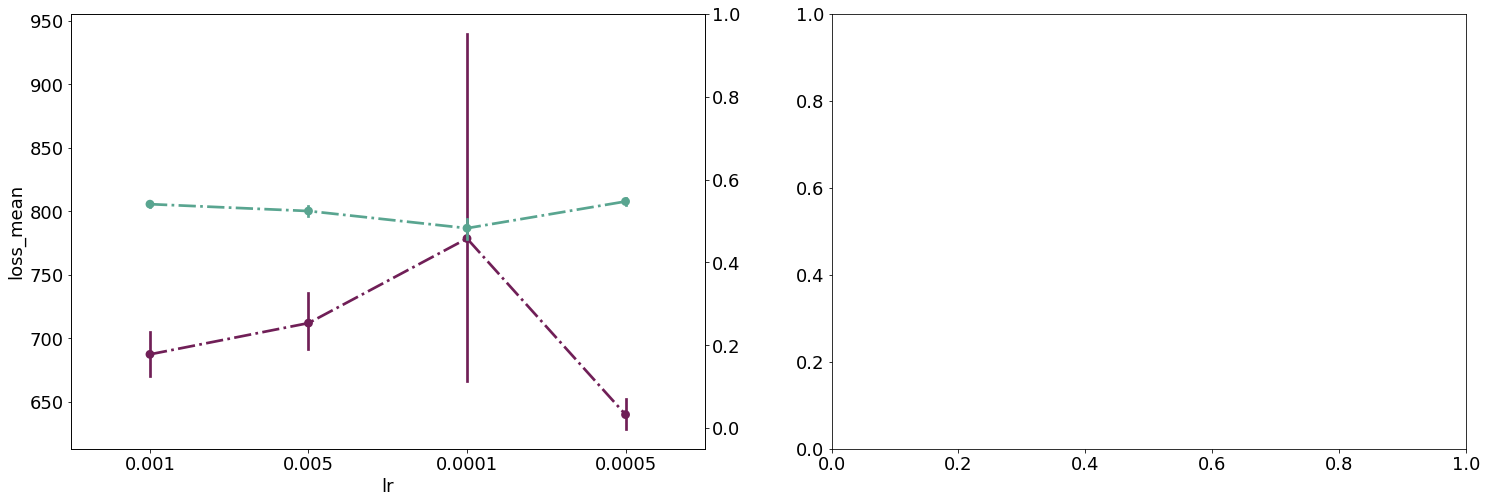

In [16]:
''' 
Collect data
'''
df_lr = pd.DataFrame.from_dict(dict_scores, orient='index').T
df_lr["loss_mean"] = df_lr["loss_mean"].astype("float")
df_lr["pearson_mean"] = df_lr["pearson_mean"].astype("float")
df_lr["pearson_mean"].replace(np.nan, 0, inplace=True)

''' 
Plot
'''
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,8))
### Val loss
sns.pointplot(data=df_lr, x="lr", y="loss_mean",linestyles = '-.', ax=ax1, color=sns.color_palette("rocket")[1])
#sns.pointplot(data=df_lr, x="lr", y="loss_mean", hue="dropr",linestyles = '-.', ax=ax2, palette="rocket")
### Reconstruction accuracy
ax3 = ax1.twinx()
sns.pointplot(data=df_lr, x="lr", y="pearson_mean",linestyles = '-.', ax=ax3, color=sns.color_palette("crest")[1])
# ax4 = ax2.twinx()
# sns.pointplot(data=df_lr, x="lr", y="pearson_mean", hue="dropr",linestyles = '-.', ax=ax4,  palette="crest")
### Aes
ax3.set_ylim(-.05,1)
ax4.set_ylim(-.05,1)
ax3.set_ylabel("")
ax2.set_ylabel("")

# Determine influence of dropout

In [10]:
''' 
Determine influence of dropout
'''
plt.rcParams.update({'font.size': 18})

### Initialise results dict
dict_scoring = dict()
for key in ["chr", "latSize", "lr", "dropr", "pearson_mean", "loss_mean"]:
    dict_scoring[key] = []

for CHR in ["chr22"]:
    ### Load Data
    PATH_results = f"logs/optimisation/{CHR}/coarse"
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_tensor = torch.tensor(test_dataset["beta"].values, dtype=torch.float32)    
    ### Parse through learning rates:
    for dropout in [0.1,0.3,0.5]:
        for folder in os.listdir(PATH_results):
            if f"dropr_{dropout}" in folder:
                path = f"{PATH_results}/{folder}"
                try:
                    dict_scores = getScores(path, 
                                            test_tensor, 
                                            dict_scoring, 
                                            save=False)
                except FileNotFoundError:
                    print(f"{folder} not finished")
                    continue
                except UnboundLocalError:
                    print(f"\t{folder}\t: UnboundLocalError")                

Text(0, 0.5, '')

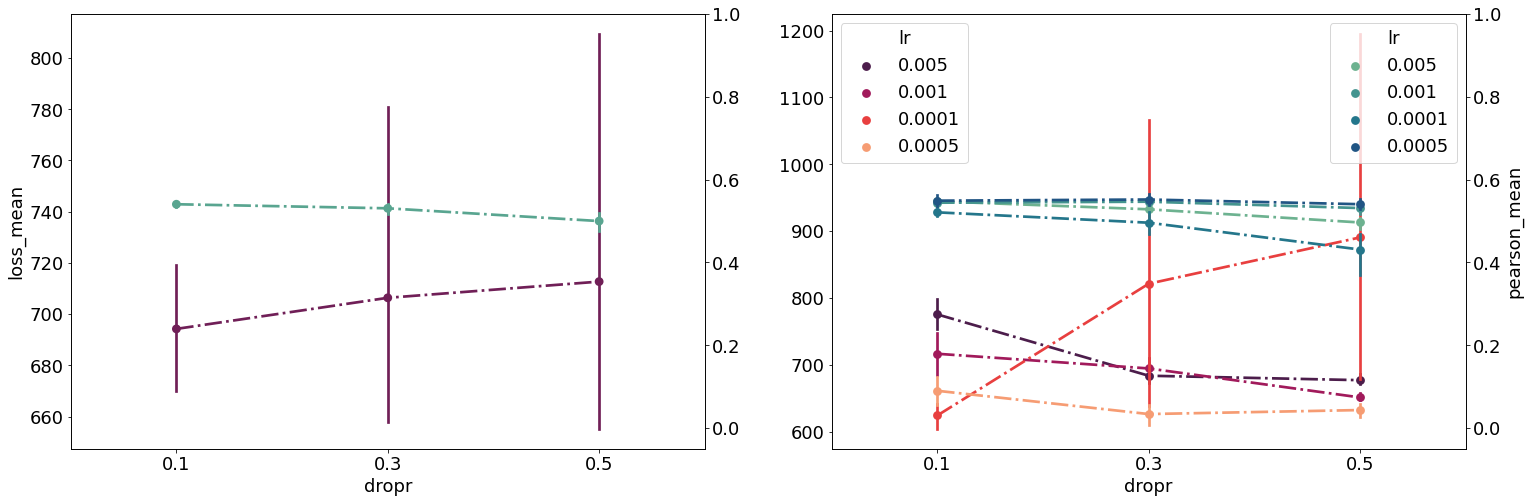

In [11]:
''' 
Collect data
'''
df = pd.DataFrame.from_dict(dict_scores, orient='index').T
df["loss_mean"] = df["loss_mean"].astype("float")
df["pearson_mean"]=df["pearson_mean"].astype("float")
df["pearson_mean"].replace(np.nan, 0, inplace=True)

''' 
Plot
'''
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,8))
### Val loss
sns.pointplot(data=df, x="dropr", y="loss_mean",linestyles = '-.', ax=ax1, color=sns.color_palette("rocket")[1])
sns.pointplot(data=df, x="dropr", y="loss_mean", hue="lr",linestyles = '-.', ax=ax2, palette="rocket")
### Reconstruction accuracy
ax3 = ax1.twinx()
sns.pointplot(data=df, x="dropr", y="pearson_mean",linestyles = '-.', ax=ax3, color=sns.color_palette("crest")[1])
ax4 = ax2.twinx()
sns.pointplot(data=df, x="dropr", y="pearson_mean", hue="lr",linestyles = '-.', ax=ax4,  palette="crest")
### Aes
ax3.set_ylim(-.05,1)
ax4.set_ylim(-.05,1)
ax3.set_ylabel("")
ax2.set_ylabel("")